In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

from pathlib import Path
from torch.utils.data import Dataset
# from torchvision.io import read_image
from PIL import Image


def _validate_root_dir(root):
    # todo: raise exception or warning
    pass

def _validate_train_flag(train: bool, valid: bool, test: bool):
    assert [train, valid, test].count(True)==1, "one of train, valid & test must be true."        

class CustomDataset(Dataset):        
    def __init__(self, root,
                 train: bool = False, valid: bool = False, test: bool = False,
                 transform=None, target_transform=None,):

        _validate_root_dir(root)
        _validate_train_flag(train, valid, test)        
        self.transform = transform
        self.target_transform = target_transform
        if train:
            self.data_dir = Path(root)/'train'
        elif valid:
            self.data_dir = Path(root)/'valid'
        elif test:
            self.data_dir = Path(root)/'test'        
    
        self._image_paths = sorted(
            list(self.data_dir.glob("**/*.jpg"))+
            list(self.data_dir.glob("**/*.jpeg"))+
            list(self.data_dir.glob("**/*.png")))
        self._image_labels = [int(i.parent.name) for i in self._image_paths]
        assert len(self._image_paths)==len(self._image_labels)
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        x = Image.open(str(self._image_paths[idx]))
        y = self._image_labels[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(x)
        return x, y
    
    def get_labels(self):
        return self._image_labels

image_size = 128
data_dir = '../data/ssddir-traffic-signs'

# train set is list of (x, y) 
# where x is single image and y is label corresponding to it.
train_set = CustomDataset(
    root=data_dir,
    train=True,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.5), int(image_size * 1.5)]),
            transforms.RandomPerspective(0.5, 0.8),
            transforms.CenterCrop(image_size),
            transforms.ColorJitter(
                brightness=0.2, contrast=0.15, saturation=0, hue=0,
            ),
            transforms.ToTensor(),
        ]
    ),
)
valid_set = CustomDataset(
    root=data_dir,
    valid=True,
    transform=transforms.Compose(
        [
            # If images have 1 channel, our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

In [2]:
N_WAY = 5 # 5  # Number of classes in a task
N_SHOT = 3 # 5  # Number of images per class in the support set
N_QUERY = 5 # 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100 

valid_sampler = TaskSampler(
    valid_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

valid_loader = DataLoader(
    valid_set,
    batch_sampler=valid_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=valid_sampler.episodic_collate_fn,
)

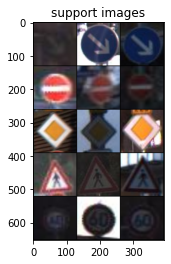

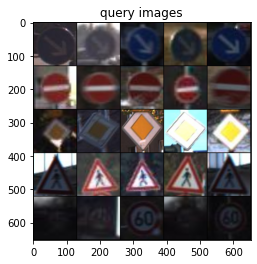

In [3]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(valid_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [4]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = PrototypicalNetworks(convolutional_network).cuda()
model = PrototypicalNetworks(convolutional_network).to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
model.eval()
example_scores = model(
    example_support_images.to(device), #.cuda(),
    example_support_labels.to(device),#.cuda(),
    example_query_images.to(device), #.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{valid_set._image_labels[example_class_ids[example_query_labels[i]]]} / {valid_set._image_labels[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
3 / 3
3 / 1
3 / 0
3 / 3
3 / 3
1 / 1
1 / 1
1 / 3
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
1 / 1
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
0 / 1
0 / 1
0 / 0
0 / 1
0 / 0


In [6]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
#             model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)#.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(valid_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]

Model tested on 100 tasks. Accuracy: 61.80%


In [7]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
#         support_images.cuda(), support_labels.cuda(), query_images.cuda()
        support_images.to(device), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.to(device))#query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  0%|▏                                                                                       | 75/40000 [01:09<10:19:30,  1.07it/s, loss=0.618]


KeyboardInterrupt: 

In [10]:
### HOLDOUT SET

In [13]:
test_set = CustomDataset(
    root=data_dir,
    test=True,
    transform=transforms.Compose(
        [
            # If images have 1 channel, our model will expect 3-channel images
            # transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
)

N_WAY = 5 # 5  # Number of classes in a task
N_SHOT = 3 # 5  # Number of images per class in the support set
N_QUERY = 5 # 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100 

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    # num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [14]:
evaluate(test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]

Model tested on 100 tasks. Accuracy: 78.76%


In [ ]:
# Run predictions on query example